#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2, Lambda, ToTensor

import cv2
from scipy import spatial
import sklearn

#### Operations on Data

In [2]:
basepath = '/content/drive/Shareddrives/ECEN_758_Project'

In [3]:
# Load data from drive

traindata = pd.read_csv(basepath + '/blob/fashion-mnist_train.csv')
testdata = pd.read_csv(basepath + '/blob/fashion-mnist_test.csv')

In [4]:
# Or get data runtime

# transforms images from PIL image formate to normalized tensors - scales image's pixel intensity value from [0,1]
# transforms integer labels to one-hot encoded tensors
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=v2.Compose([
        #v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True)
    ]),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)


test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

100%|██████████| 26421880/26421880 [00:01<00:00, 18256218.23it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 305809.84it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5478742.02it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 15163115.87it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [28]:
'''
HELPER FUNCTIONS FOR DATA PROCESSING
'''
# class dataprocessing(self, traindata, testdata) ----------> Organize for final submission

# Insights
def peekaboo(train_data, test_data):

  return ('-----TRAINDATA----', train_data['label'].value_counts()), ('----TESTDATA----',test_data['label'].value_counts()), traindata.head(), testdata.head(), traindata.describe(), testdata.describe()

# Conversion from 1D vector to 3D image matrix
def conversion_3D(data):

  images = data.drop('label', axis=1)
  print(images.shape)
  images_2d = np.array(images).reshape(len(images), 28, 28, 1)
  print(images_2d.shape)
  return images_2d

# Conversion from 1D vector to 2D image matrix
def conversion_2D(data):

  images = data.drop('label', axis=1)
  print(f'Shape of images before conversion: {images.shape}')
  images_2d = np.array(images).reshape(len(images), 28, 28)
  print(f'Shape of images after conversion: {images_2d.shape}')
  return images_2d

# Labels
def getlabels(data):

  labelsarray = np.unique(data['label'])
  typesarray = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  labels_info = {}
  for i in labelsarray:
    labels_info.update({i: typesarray[i]})

  labels = data['label']

  return labels, labels_info

# Normalize data
def normalize(data: np.array):

  return data.astype('float32') / 255

# Display images
def display(images_array: np.array, labels: np.array, labels_info: dict, n: int):

  indices = np.random.randint(len(images_array), size=n)
  plt.figure(figsize=(10, 10))

  iter = 0
  for i in indices:

    label = labels_info[labels[i]]

    plt.subplot(6, 5, iter+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(images_array[i], cmap=plt.cm.binary)
    plt.xlabel(label)
    iter += 1

# calculate hash of images
def average_hash(image, hash_size=8):
    # Resize the image to the specified hash size
    image = cv2.resize(image, (hash_size, hash_size))

    # Calculate the average pixel value
    average = np.mean(image)

    # Create a binary hash
    hash_value = 0
    for row in range(hash_size):
        for col in range(hash_size):
            if image[row, col] > average:
                hash_value |= 1 << (row * hash_size + col)

    return hash_value

def hashes(imagearray_2D: np.array):

  hashlist = []
  for i in range(len(imagearray_2D)):

    hash = average_hash(imagearray_2D[i])
    hashlist.append(hash)

  return hashlist

# cosine similarity b/w images of different classes
def cosine_similarity(hashes_array1, hashes_array2):

  result = 1 - spatial.distance.cosine(hashes_array1, hashes_array2)

  return result

# similarity dataframe
def hashdataframe(hashdict: dict, labels_info_row: dict, labels_info_col: dict):

  similarities = {}
  for i in range (len(list(hashesdict_train.values()))):

    items = []
    for j in range (len(list(hashesdict_train.values()))):
      items.append(cosine_similarity(list(hashesdict_train.values())[i], list(hashesdict_train.values())[j]))

    similarities.update({i: items})

  similarities_df = pd.DataFrame.from_dict(similarities)
  similarities_df.columns = list(labels_info_col.values())
  similarities_df.index = list(labels_info_row.values())
  return similarities_df

In [52]:
train_images = conversion_2D(traindata)
train_images = normalize(train_images)

test_images = conversion_2D(testdata)
test_images = normalize(test_images)

train_labels, labels_info = getlabels(traindata)
test_labels, _ = getlabels(testdata)

Shape of images before conversion: (60000, 784)
Shape of images after conversion: (60000, 28, 28)
Shape of images before conversion: (10000, 784)
Shape of images after conversion: (10000, 28, 28)


In [56]:
import tensorflow as tf

train_labels = tf.one_hot(train_labels, depth=10)
test_labels = tf.one_hot(test_labels, depth=10)

#### Data divided by labels

In [19]:
train_images0 = train_images[train_labels == 0]
train_images1 = train_images[train_labels == 1]
train_images2 = train_images[train_labels == 2]
train_images3 = train_images[train_labels == 3]
train_images4 = train_images[train_labels == 4]
train_images5 = train_images[train_labels == 5]
train_images6 = train_images[train_labels == 6]
train_images7 = train_images[train_labels == 7]
train_images8 = train_images[train_labels == 8]
train_images9 = train_images[train_labels == 9]
print(f'{train_images0.shape}: Train Images 0, {train_images1.shape}: Train Images 1')
print(f'{train_images2.shape}: Train Images 2, {train_images3.shape}: Train Images 3')
print(f'{train_images4.shape}: Train Images 4, {train_images5.shape}: Train Images 5')
print(f'{train_images6.shape}: Train Images 6, {train_images7.shape}: Train Images 7')
print(f'{train_images8.shape}: Train Images 8, {train_images9.shape}: Train Images 9')

train_labels0 = train_labels[train_labels == 0]
train_labels1 = train_labels[train_labels == 1]
train_labels2 = train_labels[train_labels == 2]
train_labels3 = train_labels[train_labels == 3]
train_labels4 = train_labels[train_labels == 4]
train_labels5 = train_labels[train_labels == 5]
train_labels6 = train_labels[train_labels == 6]
train_labels7 = train_labels[train_labels == 7]
train_labels8 = train_labels[train_labels == 8]
train_labels9 = train_labels[train_labels == 9]
print(f'{train_labels0.shape}: y Train Label 0, {train_labels1.shape}: y Train Label 1')
print(f'{train_labels2.shape}: y Train Label 2, {train_labels3.shape}: y Train Label 3')
print(f'{train_labels4.shape}: y Train Label 4, {train_labels5.shape}: y Train Label 5')
print(f'{train_labels6.shape}: y Train Label 6, {train_labels7.shape}: y Train Label 7')
print(f'{train_labels8.shape}: y Train Label 8, {train_labels9.shape}: y Train Label 9')

(6000, 28, 28): Train Images 0, (6000, 28, 28): Train Images 1
(6000, 28, 28): Train Images 2, (6000, 28, 28): Train Images 3
(6000, 28, 28): Train Images 4, (6000, 28, 28): Train Images 5
(6000, 28, 28): Train Images 6, (6000, 28, 28): Train Images 7
(6000, 28, 28): Train Images 8, (6000, 28, 28): Train Images 9
(6000,): y Train Label 0, (6000,): y Train Label 1
(6000,): y Train Label 2, (6000,): y Train Label 3
(6000,): y Train Label 4, (6000,): y Train Label 5
(6000,): y Train Label 6, (6000,): y Train Label 7
(6000,): y Train Label 8, (6000,): y Train Label 9


In [20]:
count_traindata, count_testdata, _, _, stats_traindata, stats_testdata = peekaboo(traindata, testdata)

In [21]:
stats_traindata

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


In [22]:
stats_testdata

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,4.500000,0.000400,0.010300,0.052100,0.077000,0.208600,0.349200,0.826700,2.321200,5.457800,...,34.320800,23.071900,16.432000,17.870600,22.860000,17.790200,8.353500,2.541600,0.629500,0.06560
std,2.872425,0.024493,0.525187,2.494315,2.208882,4.669183,5.657849,8.591731,15.031508,23.359019,...,57.888679,49.049749,42.159665,44.140552,51.706601,45.128107,28.765769,16.417363,7.462533,1.93403
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,55.000000,6.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,2.000000,45.000000,218.000000,185.000000,227.000000,223.000000,247.000000,218.000000,244.000000,...,254.000000,252.000000,255.000000,255.000000,255.000000,255.000000,240.000000,225.000000,205.000000,107.00000


In [23]:
print(f'Class Information: {labels_info}')

Class Information: {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


TRAIN IMAGES


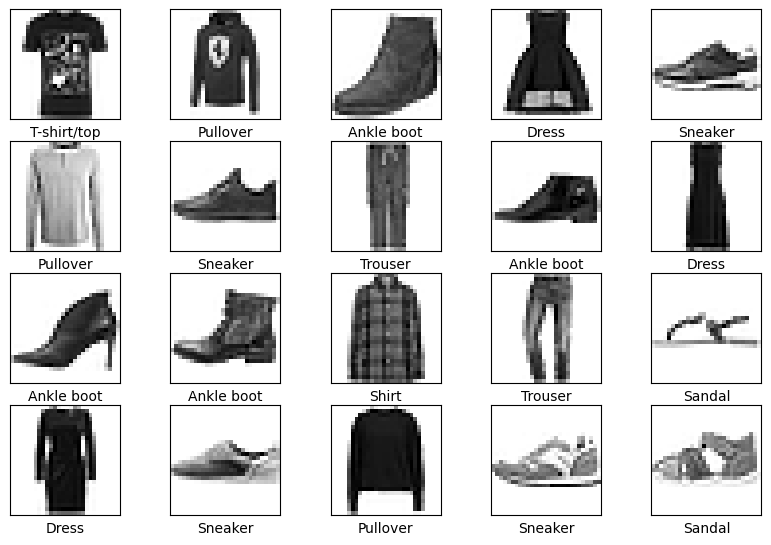

In [24]:
print('TRAIN IMAGES')
display(train_images, train_labels, labels_info, 20)

TEST IMAGES


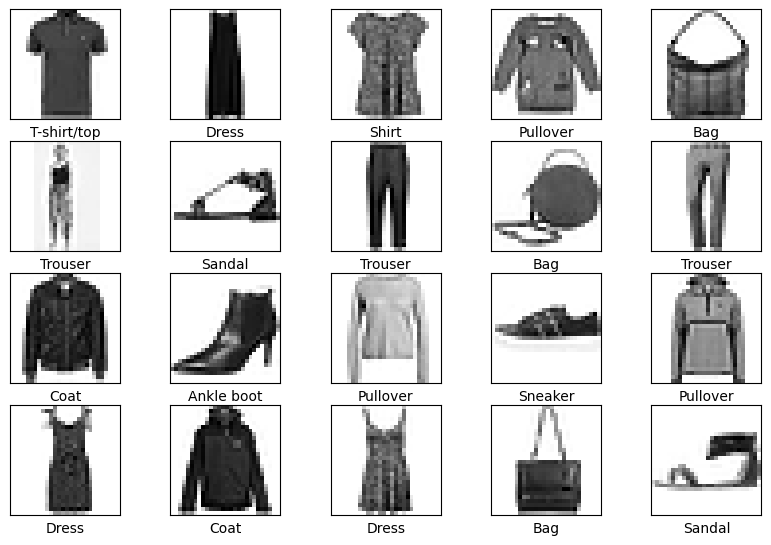

In [25]:
print('TEST IMAGES')
display(test_images, test_labels, labels_info, 20)

In [26]:
hashesdict_train = {
    'hashes_train0' : np.array(hashes(train_images0)),
    'hashes_train1' : np.array(hashes(train_images1)),
    'hashes_train2' : np.array(hashes(train_images2)),
    'hashes_train3' : np.array(hashes(train_images3)),
    'hashes_train4' : np.array(hashes(train_images4)),
    'hashes_train5' : np.array(hashes(train_images5)),
    'hashes_train6' : np.array(hashes(train_images6)),
    'hashes_train7' : np.array(hashes(train_images7)),
    'hashes_train8' : np.array(hashes(train_images8)),
    'hashes_train9' : np.array(hashes(train_images9)),
}

In [29]:
similarities_df = hashdataframe(hashesdict_train, labels_info, labels_info)

In [30]:
similarities_df

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,1.000000,0.801894,0.851795,0.853387,0.849592,0.298672,0.839034,0.031061,0.575406,0.351926
Trouser,0.801894,1.000000,0.766174,0.774505,0.766084,0.276906,0.762558,0.036903,0.515779,0.311392
Pullover,0.851795,0.766174,1.000000,0.819997,0.815088,0.284710,0.804161,0.027676,0.550867,0.340212
Dress,0.853387,0.774505,0.819997,1.000000,0.817731,0.276900,0.813487,0.033883,0.557700,0.335850
Coat,0.849592,0.766084,0.815088,0.817731,1.000000,0.288263,0.809378,0.029221,0.551583,0.321674
Sandal,0.298672,0.276906,0.284710,0.276900,0.288263,1.000000,0.283709,0.002348,0.188098,0.102530
Shirt,0.839034,0.762558,0.804161,0.813487,0.809378,0.283709,1.000000,0.030057,0.546258,0.336987
Sneaker,0.031061,0.036903,0.027676,0.033883,0.029221,0.002348,0.030057,1.000000,0.031144,0.006299
Bag,0.575406,0.515779,0.550867,0.557700,0.551583,0.188098,0.546258,0.031144,1.000000,0.230124
Ankle boot,0.351926,0.311392,0.340212,0.335850,0.321674,0.102530,0.336987,0.006299,0.230124,1.000000


<Axes: >

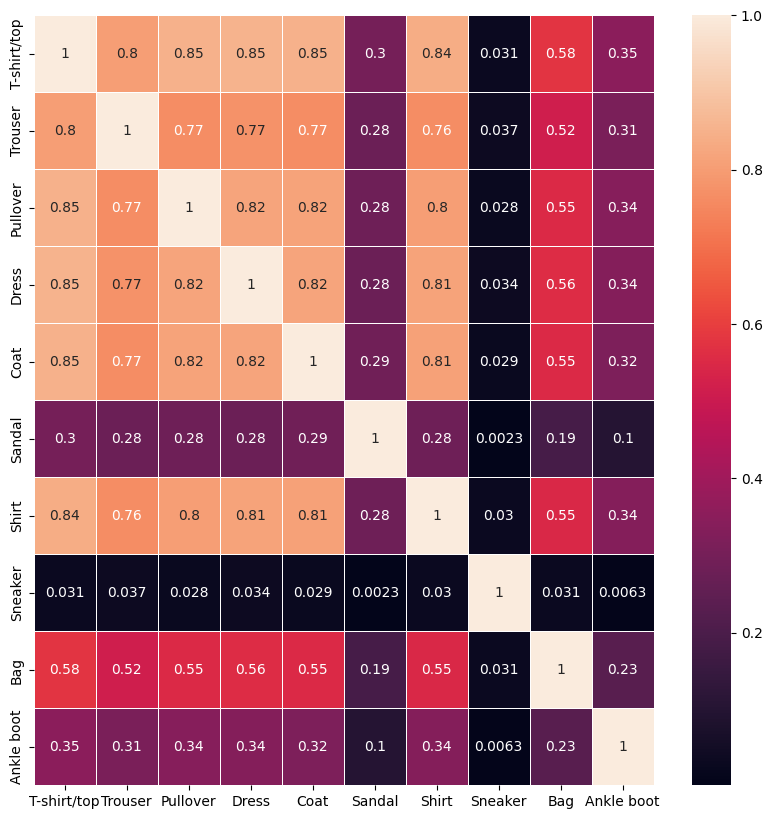

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(similarities_df, annot=True, linewidth=.5, ax=ax)

In [32]:
# descriptive statistics
# find number of samples from each class (6k each)
[out_labels, inverse_indices, counts] = torch.unique(training_data.targets, sorted=True, return_counts=True, return_inverse=True)

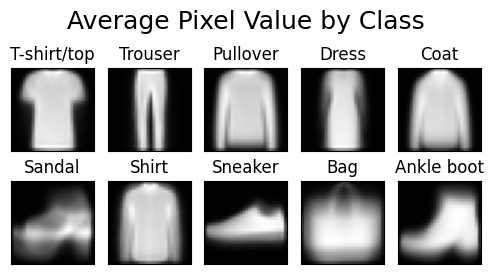

In [33]:
# get average of all pixels for each clothing type

# define figure/subplots
plt.figure(figsize=(5, 3))
#plt.subplots_adjust(hspace=0.1, wspace = 0.1)

plt.suptitle("Average Pixel Value by Class", fontsize=18, y=0.95)

nonzeros_count_avg = np.empty(10, dtype = 'object')
zeros_count_avg = np.empty(10, dtype = 'object')
avg_img_value = np.empty(20, dtype = 'object')
img_means = np.empty(10, dtype = 'object')

for n, i_label in enumerate(labels_info):
  # create mask of T/F to get indices that match class i_label
  mask = inverse_indices == i_label
  # index training data given mask
  t_class = training_data.data[mask]

  # get average number of black and non-black pixels for each class
  nonzeros_count_avg[n] = torch.count_nonzero(training_data.transform(t_class))/6000
  zeros_count_avg[n] = 28*28-nonzeros_count_avg[n]
  avg_img_value[n] = torch.mean(training_data.transform(t_class))
  avg_img_value[n+10] = torch.std(training_data.transform(t_class))


  # set axes and plot info
  ax = plt.subplot(2,5, n+1)
  img_means[n] = torch.mean(training_data.transform(t_class), 0)
  ax.imshow(torch.mean(training_data.transform(t_class), 0), cmap = "gray")
  ax.set_title(labels_info[i_label])
  ax.set_xticks([])
  ax.set_yticks([])

plt.tight_layout(h_pad = 1, w_pad=1)
plt.show

Text(0.5, 1.0, 'Average number of Non-Black Pixels')

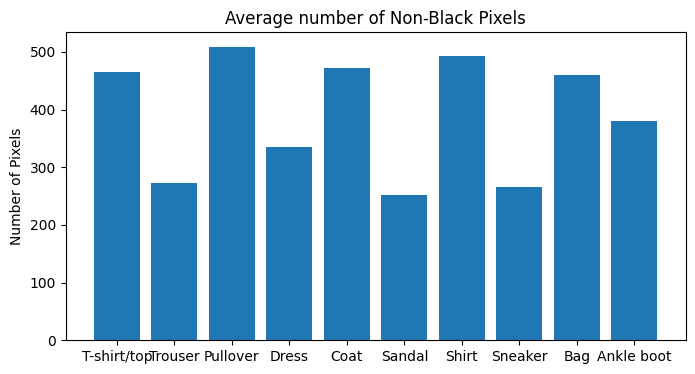

In [34]:
plt.figure(figsize=(8, 4))
plt.bar(labels_info.values(),nonzeros_count_avg)
plt.ylabel('Number of Pixels')
plt.title('Average number of Non-Black Pixels')

Text(0.5, 1.0, 'Average pixel value for each class')

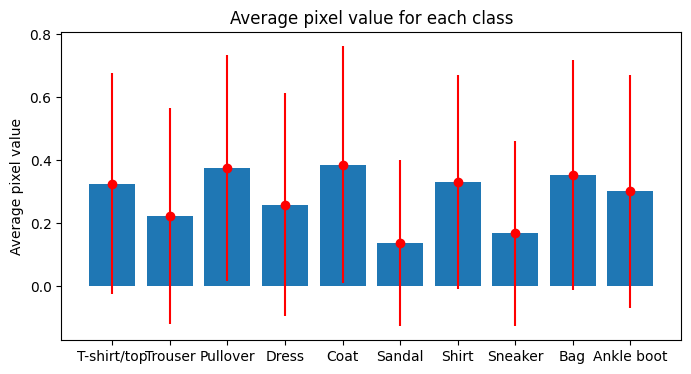

In [35]:
plt.figure(figsize=(8, 4))
plt.bar(labels_info.values(),avg_img_value[0:10])
plt.errorbar(labels_info.values(),avg_img_value[0:10], yerr = avg_img_value[10:20], fmt='o', color='r')
plt.ylabel('Average pixel value')
plt.title('Average pixel value for each class')

<function matplotlib.pyplot.show(close=None, block=None)>

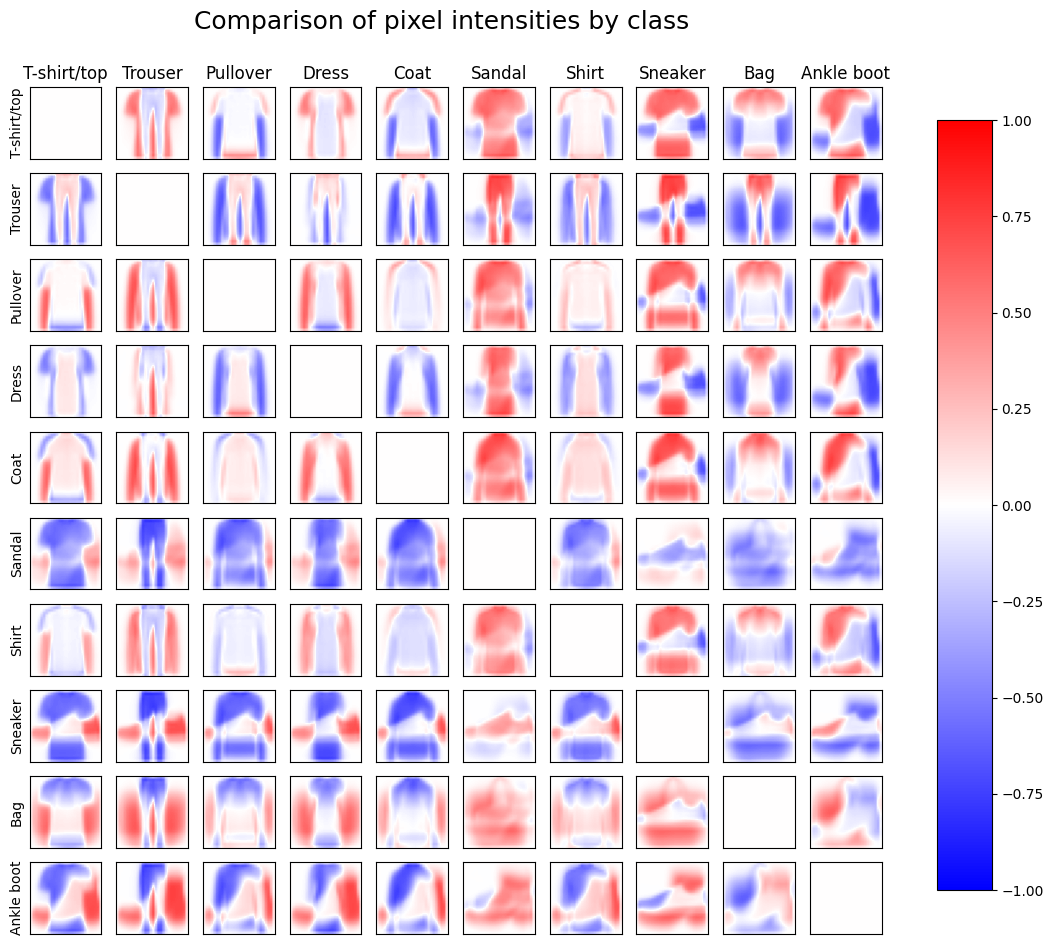

In [36]:
# pairwise comparison of classes

# define figure/subplots
fig = plt.figure(figsize=(11, 11))
#fig.subplots_adjust(hspace=0, wspace = 0)
fig.tight_layout()
fig.suptitle("Comparison of pixel intensities by class", fontsize=18, y=0.95)
p = 1;
for j, avg_outer in enumerate(img_means):
  for k, avg_inner in enumerate(img_means):
    # find difference between average of 2 classes
    diff1 = avg_outer - avg_inner

    # set axes and plot info
    ax = plt.subplot(10,10, p)
    im = ax.imshow(diff1, cmap="bwr", vmin = -1, vmax = 1 )
    #ax.set_title(labels[i_label])
    ax.set_xticks([])
    ax.set_yticks([])

    if j == 0:
      ax.set_title(labels_info[k])
    if k == 0:
      ax.set_ylabel(labels_info[j])

    p = p + 1



fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show